In [1]:
import pandas as pd
import numpy as np

import statsmodels.stats.multitest as smm
from statsmodels.stats.weightstats import *

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Дані - степінь експресії генів у трьох групах: normal (здорові жінки), early neoplasia (рання стадія раку грудей), 
cancer (сильно виражені симптоми хвороби).
Дослідження було проведено в Stanford School of Medicine.

In [3]:
df = pd.read_csv('gene_high_throughput_sequencing.csv')

In [4]:
df.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


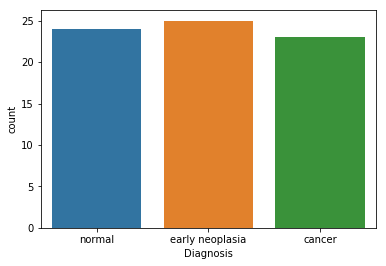

In [5]:
sns.countplot(df.Diagnosis);

Бачимо, що к-сть обєктів у трьох групах зрівноважена

In [6]:
df.Diagnosis.value_counts()

early neoplasia    25
normal             24
cancer             23
Name: Diagnosis, dtype: int64

### Перевіримо, що розподіли у вибірках суттєво не відрізняються від нормальних за допомогою тесту Шапіро-Уілка:

In [7]:
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(df.LOC643837))
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(df.LOC100130417))

Shapiro-Wilk normality test, W-statistic: 0.899314, p-value: 0.000029
Shapiro-Wilk normality test, W-statistic: 0.912100, p-value: 0.000097


In [8]:
shapiro_test_normal = {}

for col in df.columns[2:]:    
    s = stats.shapiro(df.loc[df.Diagnosis=="normal", col])[1]
    if s >= 0.05:
        shapiro_test_normal[col] = s

len(shapiro_test_normal)

11614

In [9]:
shapiro_test_early = {}

for col in df.columns[2:]:    
    s = stats.shapiro(df.loc[df.Diagnosis=="early neoplasia", col])[1]
    if s >= 0.05:
        shapiro_test_early[col] = s

In [10]:
len(shapiro_test_early)

11815

In [45]:
shapiro_test_cancer = {}

for col in df.columns[2:]: 
    s = stats.shapiro(df.loc[df.Diagnosis=="cancer", col])[1]
    if s >= 0.05:
        shapiro_test_cancer[col] = s

In [46]:
len(shapiro_test_cancer)

11495

1. У групі здорових жінок для 11614 з 15748 вибірок не відхиляється нульова гіпотеза про нормальність.
2. У групі жінок з початковою стадією раку для 11815 вибірок не відхиляється нульова гіпотеза про нормальність.
3. У групі жінок з вираженими симптомами раку для 11495 вибірок не відхиляється нульова гіпотеза про нормальність.

Серед отриманих вибірок є ті, у яких p-value менше 0.05, тобто відхиляється Н0 на рівні значимості 0.05

### t-критерій Стюдента для двох незалежних вибірок:

Незважаючи на присутність вибірок у яких відхиляється гіпотеза про нормальність, використаєм t-критерій Стюдента
для перевірки гіпотези про рівність середніх двох вибірок.


##### 1. Для груп normal (control) і early neoplasia (treatment)

In [12]:
t_normal_early = []

for col in df.columns[2:]:
    t_normal_early.append(stats.ttest_ind(df.loc[df.Diagnosis=="normal", col], \
                                         df.loc[df.Diagnosis=="early neoplasia", col])[1] )

normal_early = pd.DataFrame(data=t_normal_early, index=df.columns[2:], columns=["t_ind"])

In [13]:
normal_early[normal_early.t_ind < 0.05].shape

(1583, 1)

Для 1583 генів відхиляється H0 про рівність їх середніх у групах normal(control) та early neoplasia(treatment) на рівні значимості 0.05 

##### 2. Для груп early neoplasia (control) і cancer (treatment)

In [14]:
t_early_cancer = []

for col in df.columns[2:]:
    t_early_cancer.append(stats.ttest_ind(df.loc[df.Diagnosis=="early neoplasia", col], \
                                          df.loc[df.Diagnosis=="cancer", col])[1] )
    
early_cancer = pd.DataFrame(data=t_early_cancer, index=df.columns[2:], columns=["t_ind"])


In [15]:
early_cancer[early_cancer.t_ind < 0.05].shape

(3529, 1)

Для 3529 генів відхиляється H0 про рівність їх середніх у групах early(control) та cancer(treatment) на рівні значимості 0.05 

### Множинна перевірка гіпотез: поправка Холма-Бонферронні

 Після поправки Холма проблема з множинною перевіркою залишається, так як поправку Холма робимо окремо для кожного з двох
наборів p-value, які були отримані раніше.
Тому застосовуємо поправку Бонферроні, тобто рівень значимості тепер 0.5/2 .

In [16]:
reject, p_corrected, a1, a2 = smm.multipletests(normal_early.t_ind, alpha = 0.025, method = 'holm') 
normal_early['p_corrected_hb'] = p_corrected
normal_early['rejected_hb'] = reject

Fold change - визначає практичну значимість зміни експресії. С і Т - середні значення експресії гена в contrlo
і treatment групах відповідно

In [17]:
fold_change_1 = []
for col in df.columns[2:]:
    C = df.loc[df.Diagnosis=="normal", col].mean()
    T = df.loc[df.Diagnosis=="early neoplasia", col].mean()
    if T >= C:
        fold_change_1.append(T/C)
    else:
        fold_change_1.append(-C/T)

normal_early['fold_change'] = fold_change_1

In [18]:
normal_early.head()

,t_ind,p_corrected_hb,rejected_hb,fold_change
LOC643837,0.690597,1.000000,False,-1.067858
LOC100130417,0.000033,0.514589,False,1.996517
SAMD11,0.058455,1.000000,False,1.222418
NOC2L,0.825984,1.000000,False,-1.020070
KLHL17,0.050391,1.000000,False,1.125471


In [19]:
normal_early.rejected_hb.value_counts()

False    15746
True         2
Name: rejected_hb, dtype: int64

In [22]:
normal_early[(normal_early.rejected_hb==True)&(abs(normal_early.fold_change)>1.5)]

,t_ind,p_corrected_hb,rejected_hb,fold_change
PCSK4,6.256978e-07,0.009853,True,1.509785
EEF1A2,5.324929e-08,0.000839,True,1.974868


In [21]:
normal_early[(normal_early.t_ind < 0.05)&(abs(normal_early.fold_change)>1.5)].shape

(216, 4)

При врахуванні поправки Холма-Бонферроні було відхилено дві нульові гіпотези про рівність середньої експресії гену у групах normal та early neoplasia. Тобто спостерігаються дві значимі зміни із практична значимість(fold change) для цих генів перевищує 1.5 . Тоді ж як t-критерій Стюдента відхиляє 216 нульових гіпотез при врахуванні практичної значимості.

In [24]:
reject, p_corrected, a1, a2 = smm.multipletests(early_cancer.t_ind, alpha = 0.025, method = 'holm') 
early_cancer['p_corrected_hb'] = p_corrected
early_cancer['rejected_hb'] = reject

In [25]:
fold_change_2 = []
for col in df.columns[2:]:
    C = df.loc[df.Diagnosis=="early neoplasia", col].mean()
    T = df.loc[df.Diagnosis=="cancer", col].mean()
    if T >= C:
        fold_change_2.append(T/C)
    else:
        fold_change_2.append(-C/T)

early_cancer['fold_change'] = fold_change_2

In [26]:
early_cancer.head()

,t_ind,p_corrected_hb,rejected_hb,fold_change
LOC643837,0.416764,1.0,False,-1.148593
LOC100130417,0.650072,1.0,False,-1.064871
SAMD11,0.067484,1.0,False,1.278517
NOC2L,0.287644,1.0,False,1.092635
KLHL17,0.470720,1.0,False,1.036574


In [27]:
early_cancer.rejected_hb.value_counts()

False    15663
True        85
Name: rejected_hb, dtype: int64

In [28]:
early_cancer[(early_cancer.rejected_hb == True)&(abs(early_cancer.fold_change)>1.5)].shape

(82, 4)

In [29]:
early_cancer[(normal_early.t_ind < 0.05)&(abs(early_cancer.fold_change)>1.5)].shape

(193, 4)

При врахуванні поправки Холма-Бонферроні було відхилено 82 нульові гіпотези про рівність середньої експресії гену у групах early neoplasia та cancer. Тобто спостерігаються 82 значимі зміни із практична значимість(fold change) для цих генів перевищує 1.5 . Тоді ж як t-критерій Стюдента відхиляє 193 нульових гіпотез при врахуванні практичної значимості.

### Поправка методом Бенджаміні-Хохберга

In [30]:
reject, p_corrected, a1, a2 = smm.multipletests(normal_early.t_ind, alpha = 0.025, method = 'fdr_bh') 
normal_early['p_corrected_bh'] = p_corrected
normal_early['rejected_bh'] = reject

In [31]:
normal_early.head()

,t_ind,p_corrected_hb,rejected_hb,fold_change,p_corrected_bh,rejected_bh
LOC643837,0.690597,1.000000,False,-1.067858,0.966207,False
LOC100130417,0.000033,0.514589,False,1.996517,0.028613,False
SAMD11,0.058455,1.000000,False,1.222418,0.528231,False
NOC2L,0.825984,1.000000,False,-1.020070,0.980757,False
KLHL17,0.050391,1.000000,False,1.125471,0.499289,False


In [32]:
normal_early.rejected_bh.value_counts()

False    15744
True         4
Name: rejected_bh, dtype: int64

In [33]:
normal_early[normal_early.rejected_bh==True]

,t_ind,p_corrected_hb,rejected_hb,fold_change,p_corrected_bh,rejected_bh
TMEM63C,1.880097e-06,0.029602,False,1.663826,0.007402,True
PCSK4,6.256978e-07,0.009853,True,1.509785,0.004927,True
CACNG8,1.708786e-06,0.026907,False,1.754951,0.007402,True
EEF1A2,5.324929e-08,0.000839,True,1.974868,0.000839,True


При врахуванні поправки Бенджаміні-Хохберга було відхилено 4 нульові гіпотези про рівність середньої експресії гену у групах normal та early neoplasia. Тобто спостерігаються 4 значимі зміни і практична значимість(fold change) для цих генів перевищує 1.5 .

In [34]:
reject, p_corrected, a1, a2 = smm.multipletests(early_cancer.t_ind, alpha = 0.025, method = 'fdr_bh') 
early_cancer['p_corrected_bh'] = p_corrected
early_cancer['rejected_bh'] = reject

In [35]:
early_cancer.head()

,t_ind,p_corrected_hb,rejected_hb,fold_change,p_corrected_bh,rejected_bh
LOC643837,0.416764,1.0,False,-1.148593,0.676582,False
LOC100130417,0.650072,1.0,False,-1.064871,0.834203,False
SAMD11,0.067484,1.0,False,1.278517,0.263054,False
NOC2L,0.287644,1.0,False,1.092635,0.561734,False
KLHL17,0.470720,1.0,False,1.036574,0.717470,False


In [36]:
early_cancer.rejected_bh.value_counts()

False    14840
True       908
Name: rejected_bh, dtype: int64

In [37]:
early_cancer[(early_cancer.rejected_bh == True)&(abs(early_cancer.fold_change)>1.5)].shape

(560, 6)

При врахуванні поправки Бенджаміні-Хохберга було відхилено 560 нульові гіпотези про рівність середньої експресії гену у групах early neoplasia та cancer. Тобто спостерігаються 560 значимі зміни і практична значимість(fold change) для цих генів перевищує 1.5 .

###### К-сть відхилених і прийнятих гіпотез H0 про рівність середніх у двох вибірках при врахуванні практичної значимості

<table>
    <tr>
    <th> </th>
    <th>H0 accept (normal and early)</th>
    <th>H0 reject (normal and early)</th>
    <th>H0 accept (early and cancer)</th>
    <th>H0 reject (early and cancer)</th>
    </tr>    
    <tr>
    <td>t-Student test</td>
    <td>15532</td>
    <td>216</td>
    <td>15555</td>
    <td>193</td>
    </tr>
    <tr>
    <td>Holm-Bonferroni correction</td>
    <td>15746</td>
    <td>2</td>
    <td>15666</td>
    <td>82</td>
    </tr>
    <tr>
    <td>Benjamini-Hochberg correction</td>
    <td>15744</td>
    <td>4</td>
    <td>15188</td>
    <td>560</td>
    </tr>
</table>

Метод Benjamini-Hochberg контролює FDR і тому має більшу потужність, ніж метод Холма,який контролює FWER. FDR методи краще вловлюють відхилення від Н0, коли дійсно відхилення є, і частіше відхиляють Н0, коли насправді відмінностей немає. При неправильно поставленому діагнозі пацієнтам буде назначено лікування (можливо хіміотерапія), що призведе до важких наслідків.